## Figures for:
# Establishing evidence for prediction: a review of pitfalls and solutions

### Russell A. Poldrack[1], Grace Huckins[1], and Gael Varoquaux[2]


In [1]:
import numpy,pandas
import seaborn
import sklearn
# check for sufficient sklearn version
sklv = int(sklearn.__version__.split('.')[1])
assert sklv >= 20
from sklearn.linear_model import LinearRegression,LogisticRegression,LogisticRegressionCV
from sklearn import model_selection,metrics
from statsmodels.regression.linear_model import OLS
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import LeaveOneOut,ShuffleSplit,cross_validate
import numpy as np
import csv
from matplotlib import pyplot as plt
from collections import Counter

import matplotlib.pyplot as plt

numpy.random.seed(12345)  # set random seed to exactly reproduce results

# this imports a function to do balanced cross validation
from get_balanced_folds import BalancedKFold

%matplotlib inline

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['figure.titlesize'] = 15
plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 17

#_ = plt.title('Subdisciplines', size=15)
#plt.xticks(size=15)
#plt.yticks(size=15)


/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


### Figure 1: Overfitting and prediction

In [116]:
# Figure 1
# true model is quadratic (order 2)
# we generate data from this model and fit models of varying complexity

nruns = 1000 # number of simulation runs to get more stable MSE plot
npts = 20 # number of data points
noise_sd = 2 # noise standard deviation

#numpy.random.seed(144) # set random seed for consistent data
# randomly initialize the RNG from some platform-dependent source of entropy
seed = 2202704308 # numpy.random.randint(2**32 - 1)
# print(seed)
numpy.random.seed(seed)
# get the initial state of the RNG

max_order = 8
model_order_range = max_order + 1
use_rmse = True

lm = {}
coefs={}
model_X = {}
cv_results = {}

mse = {'train': numpy.zeros((nruns, model_order_range)),
        'test': numpy.zeros((nruns, model_order_range)),
        'cv': numpy.zeros((nruns, model_order_range))}

for run in range(nruns):
    x = numpy.random.randn(2*npts)
    x = StandardScaler().fit_transform(x[:,numpy.newaxis])

    X_all = PolynomialFeatures(degree=2).fit_transform(x)
    beta=[10,3,3]
    X = X_all[:npts]
    X_test = X_all[npts:]
    Y_train = X.dot(beta) + numpy.random.randn(npts)*noise_sd
    Y_test = X_test.dot(beta) + numpy.random.randn(npts)*noise_sd

    lm[run] = {}
    coefs[run] = {}
    cv_results[run] = {}
    for model_order in range(model_order_range):
        model_X[model_order] = PolynomialFeatures(degree=model_order).fit_transform(x)
        lm[run][model_order] = LinearRegression(fit_intercept=False)
        lm[run][model_order].fit(model_X[model_order][:npts], Y_train)
        coefs[run][model_order] = lm[run][model_order].coef_
        mse['train'][run, model_order] = numpy.mean((Y_train - lm[run][model_order].predict(model_X[model_order][:npts]))**2)
        mse['test'][run, model_order] = numpy.mean((Y_test - lm[run][model_order].predict(model_X[model_order][npts:]))**2)

        # also compute cross-validation score
        cv_results[run][model_order] = model_selection.cross_validate(LinearRegression(fit_intercept=False),
                                                   model_X[model_order][:npts],
                                                   Y_train,cv=4,
                                                   scoring='neg_mean_squared_error',
                                                   return_train_score=False)
        mse['cv'][run, model_order] = -1*numpy.mean(cv_results[run][model_order]['test_score'])
        if use_rmse:
            for msetype in mse.keys():
                mse[msetype][run, model_order] = numpy.sqrt(mse[msetype][run, model_order])
            



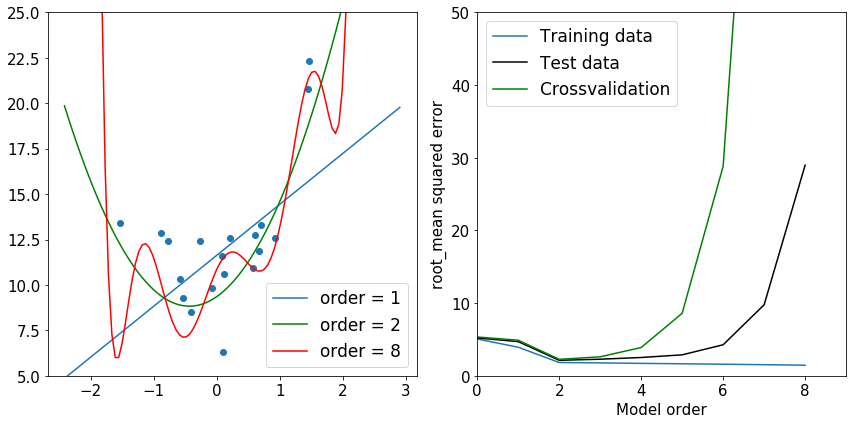

In [120]:
# plot data points vs model fits
x_test = np.linspace(x.min(), x.max(), 100)
x_test = x_test[:,numpy.newaxis]

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(x[:npts],Y_train)
run_to_show = 1
plt.plot(x_test,lm[run_to_show][1].predict(PolynomialFeatures(degree=1).fit_transform(x_test)))
plt.plot(x_test,lm[run_to_show][2].predict(PolynomialFeatures(degree=2).fit_transform(x_test)),color='g')
plt.plot(x_test,lm[run_to_show][max_order].predict(PolynomialFeatures(degree=max_order).fit_transform(x_test)),color='r')
plt.ylim([5,25])
plt.legend(['order = 1', 'order = 2', 'order = %s' % max_order])
# perform crossvalidation to estimate out-of-sample fit


# plot MSE

plt.subplot(1,2,2)
plt.plot(numpy.median(mse['train'], 0))
plt.plot(numpy.median(mse['test'], 0), color='k')
plt.plot(numpy.median(mse['cv'], 0), color='g')
plt.axis([0, model_order_range, 0, 50])

plt.ylabel('%smean squared error' % 'root_' if use_rmse else '' )
plt.xlabel('Model order')
plt.legend(['Training data', 'Test data', 'Crossvalidation'])
plt.tight_layout()
plt.savefig('Figure1_overfitting.png')

*Figure 1*: A depiction of overfitting.  Left: A simulated dataset generated from a quadratic model (i.e., polynomial order = 2), shown in blue dots.  The best fitting models are shown for order 1 (linear; blue), order 2 (quadratic; green), and order 8 (red).  The complex model clearly overfits the dataset, adapting itself to the noise evident in specific datapoints.  Right: The mean squared error (MSE) for the model assessed against the dataset used to train the model (blue), and against a separate dataset sampled from the same generative process with different random measurement error (black); plot represents median MSE values over 1000 simulation runs.  The MSE decreases for the training dataset as the complexity increases, whereas for the test dataset the MSE is lowest for order = 2 (i.e. the true model).  The MSE estimated using cross validation (green) is also lowest for the true model; note that it takes very large values for model orders greater than 5, falling outside the axes of the chart.

### Predicting rare outcomes

In [3]:
sensitivity = 0.99
specificity = 0.99

prevalence = 1/138
nTests = 1000000

nFalseAlarms = nTests*(1-specificity)
nHits = nTests*prevalence*sensitivity

print('FA',nFalseAlarms)
print('hits',nHits)



FA 10000.00000000001
hits 7173.913043478261


### Figure 2: Optimism



In [4]:
## Simulate optimism as a function of model size

def logistic_simulation(npts = 100, p_disease = 0.5,
                        nvars = 40, noise_sd = 2.5,
                        betaval=2, cv=model_selection.KFold(4, shuffle=True)):
    # design matrix
    # first column reflects healthy (0) vs disease (1)
    # remaining columns are random noise
    X = numpy.zeros((2*npts,1))
    # Created disease in data used for model fitting
    X[:int(npts*p_disease)]=1
    # Created disease in data used for validation
    X[npts:(npts + int(npts*p_disease))]=1
    #X = X - numpy.mean(X)
    if nvars > 1:
        noise = numpy.random.randn(npts*2*(nvars-1)).reshape((2*npts,nvars-1))
        noise = StandardScaler().fit_transform(noise)
        X = numpy.hstack((X,noise))
    betas = numpy.zeros(nvars)

    # only the disease variable has true relationship
    betas[0] = betaval
    Y = X.dot(betas) + numpy.random.randn(2*npts)*noise_sd
    Y = (Y > 0).astype('int')

    # create a left-out dataset to compare to CV
    X_new = X[npts:]
    Y_new = Y[npts:]
    X = X[:npts]
    Y = Y[:npts]

    acc = {'insample':numpy.zeros(nvars),
           'newdata':numpy.zeros(nvars),
           'cv':numpy.zeros(nvars)}


    lr = LogisticRegression(solver='lbfgs', fit_intercept=True)

    for i in range(nvars):
        X_i = X[:,:(i+1)]
        X_i_new = X_new[:,:(i+1)]
        lr.fit(X_i,Y)
        acc['insample'][i] = metrics.accuracy_score(Y,lr.predict(X_i))
        acc['newdata'][i] = metrics.accuracy_score(Y_new,lr.predict(X_i_new))

        cv_results = model_selection.cross_validate(LogisticRegression(solver='lbfgs',
                                                                       fit_intercept=True),
                                                   X_i,
                                                   Y,cv=cv,
                                                   scoring='accuracy',
                                                   return_train_score=True)
        acc['cv'][i] = numpy.mean(cv_results['test_score'])
        #acc['insample'][i] = numpy.mean(cv_results['train_score'])

    return(acc)



In [5]:
# run simulations
acc_estimates = []
nruns = 1000
nvars=40
for i in range(nruns):
    acc_estimates.append(logistic_simulation(betaval=0,
                                             nvars=nvars))
    
# summarize accuracy data
acc = {'insample':[],
        'newdata':[],
        'cv':[]}

for i in range(len(acc_estimates)):
    for k in acc:
        if i == 0:
            acc[k] = acc_estimates[i][k]
        else:
            acc[k] = numpy.vstack((acc[k],acc_estimates[i][k]))

all_acc=[]
for k in acc:
    acc[k] = pandas.DataFrame(acc[k]).melt()
    acc[k]['vartype'] = k
    if len(all_acc) == 0:
        all_acc = acc[k]
    else:
        all_acc = pandas.concat((all_acc,acc[k]))


In [6]:
# simulate overfitting as a function of sample size

numpy.random.seed(12345)  # set random seed to exactly reproduce results

acc_estimates_sampsize = {}
nruns = 1000
sampsizes = 2**numpy.arange(5,11)

for i,sampsize in enumerate(sampsizes):
    acc_estimates_sampsize[sampsize] = []
    for j in range(nruns):
        acc_estimates_sampsize[sampsize].append(logistic_simulation(npts=sampsize,
                                                                nvars=5,betaval=0))
        
# summarize sample size data
acc_sampsize = {'insample':numpy.zeros((nruns,len(sampsizes))),
        'newdata':numpy.zeros((nruns,len(sampsizes))),
        'cv':numpy.zeros((nruns,len(sampsizes)))}


for i in range(nruns): # simulations
    for j,sampsize in enumerate(sampsizes): # sample sizes
        for k in acc_sampsize: # measures 
            acc_sampsize[k][i,j] = acc_estimates_sampsize[sampsize][i][k][0]

all_acc_sampsize=[]
for k in acc_sampsize:
    acc_sampsize[k] = pandas.DataFrame(acc_sampsize[k],columns=sampsizes).melt()
    acc_sampsize[k]['vartype'] = k
    if len(all_acc_sampsize) == 0:
        all_acc_sampsize = acc_sampsize[k]
    else:
        all_acc_sampsize = pandas.concat((all_acc_sampsize,acc_sampsize[k]))



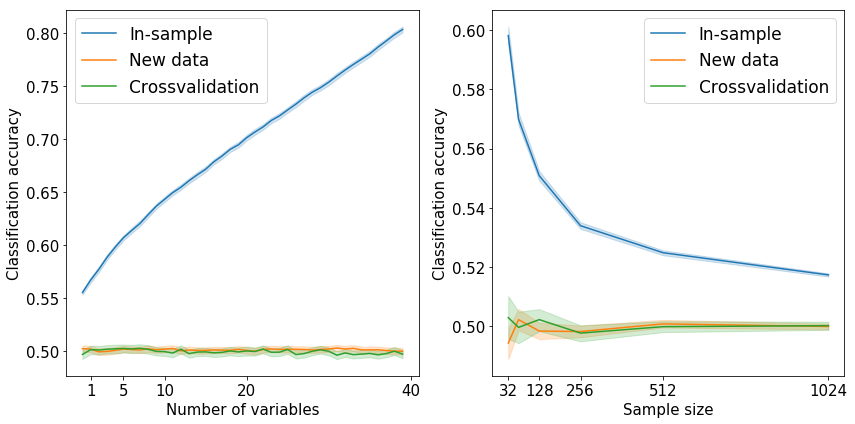

In [7]:
# make figure
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
seaborn.lineplot(x='variable',y='value',hue='vartype',data=all_acc)
plt.ylabel('Classification accuracy')
plt.xlabel('Number of variables')
plt.legend(['In-sample','New data','Crossvalidation'])
plt.xticks([1,5,10,20,40])

# plot sample size data
plt.subplot(1,2,2)
seaborn.lineplot(x='variable',y='value',hue='vartype',data=all_acc_sampsize)
plt.ylabel('Classification accuracy')
plt.xlabel('Sample size')
plt.legend(['In-sample','New data','Crossvalidation'])
plt.xticks([32,128,256,512,1024])
plt.tight_layout()
plt.savefig('Figure2_optimism.png')

*Figure 2*: Left panel: Classification accuracy as a function of the number of variables in the model.  The data were generated using a single variable (which is the first variable in the list of variables); the remaining variables were simply random normal variables with no intended relationship to the outcome.  The blue line shows that in-sample classification accuracy is heavily inflated by the presence of unrelated variables in the model, due to the fitting of noise in those variables. The black line shows the results for testing the fitted model to a new dataset generated in the same way, and the green line shows the accuracy results using crossvalidation.  Crossvalidation prevents the inflated estimate of prediction accuracy, providing an estimate that is much more similar to that expected with a new dataset.  Right panel: Classification accuracy for the model with 5 variables (1 true generating variable and 4 noise variables) as a function of sample size.  Optimism (the difference between in accuracy between in-sample and crossvalidated/new data accuracy) is substantially higher for smaller sample sizes.  Shaded areas indicate 95% confidence intervals estimated via the bootstrap.

### Figure 3: Literature Review

In [8]:
# load data
data = pandas.read_csv('litreviewdata.csv')   


#### Plot cross-validation methods


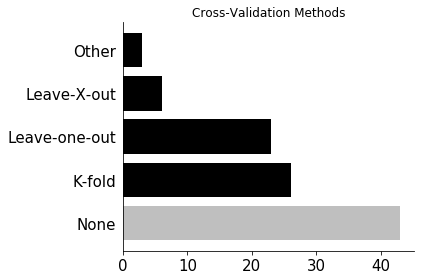

In [9]:
cvtypes = data.CV
# split LOO/Kfold into separate entries to be counted
ncombo = data.query('CV=="LOO, k-fold"').shape[0]
cvtypes = cvtypes.replace('LOO, k-fold','LOO')
for i in range(ncombo):
    cvtypes = cvtypes.append(pandas.Series(['K-fold']))


unique, counts = np.unique(cvtypes, return_counts=True)
idx = numpy.argsort(counts)[::-1]
unique = unique[idx]
counts = counts[idx]
full_label={'None':'None','K-fold':'K-fold',
            'LOO':'Leave-one-out',
           'LXO':'Leave-X-out',
           'Other':'Other',
           'LOO, k-fold':'Leave-one-out/K-fold'}
full_labels = [full_label[i] for i in unique.tolist()]

explode = (0,0.1,0.1,0,0)
plt.barh(full_labels, counts, color=['0.75','k','k','k','k','k'])
for tick in plt.gca().yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)

_ = plt.title('Cross-Validation Methods')
seaborn.despine(top=True, right=True)

plt.tight_layout()

plt.savefig('Figure3a_cvtypes.png')


#### sample sizes

Proportion of samples smaller than 50: 0.56
Proportion of samples smaller than 20: 0.18


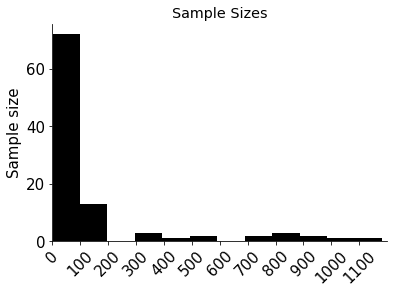

In [19]:
plt.hist(data.n,bins=12,color='k')
plt.xticks(np.arange(0,1200,step=100), rotation=45)
plt.xlim(0,1200)
plt.ylabel('Sample size')
_ = plt.title('Sample Sizes')

print('Proportion of samples smaller than 50:',np.mean(data.n<50))
print('Proportion of samples smaller than 20:',np.mean(data.n<20))
seaborn.despine(top=True, right=True)


plt.savefig('Figure3b_samplesizes.png')

#### Use of correlation as metric

In [11]:
n_corrs = 0
n_regression = 0
for i in range(data.shape[0]):
    s=data.Metric.iloc[i]
    t=data['Classification or regression?'].iloc[i]
    if not isinstance(s, str) or not isinstance(t, str):
        continue
    if not t.lower().find('regression')>-1:
        continue
    n_regression +=1
    s_l = s.lower()
    if s.find('correlation')>-1:
        n_corrs += 1
print(n_corrs,n_regression,n_corrs/n_regression)

30 64 0.46875


#### Extra: Plot subdisciplines

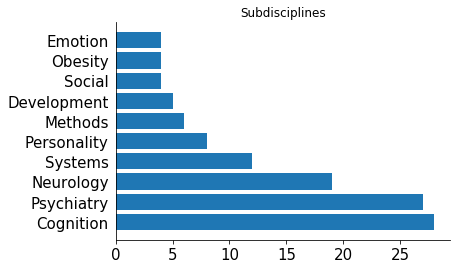

In [12]:

fields = []
for f in data.Subarea:
    for a in f.split(','):
        fields.append(a.strip().replace('Weight Gain/Loss','Obesity'))

a,b = np.unique(fields, return_counts=True)
idx = numpy.argsort(b)[::-1]
a = a[idx]
b = b[idx]
fig,ax = plt.subplots()
ax.barh(a,b)
for tick in ax.yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
_ = plt.title('Subdisciplines')
seaborn.despine(top=True, right=True)

plt.savefig('subdisciplines.png')

## Quantifying classification accuracy

Take the following example of a predictive model for a disease that occurs in one out of every 1000 individuals:

|       Test result/Disease        | No disease | Disease |
|---------------|------------|---------|
| Predict disease | 0          | 0       |
| Predict no disease | 999        | 1       |




In [13]:
disease = numpy.zeros(1000)
disease[0] = 1
prediction = numpy.zeros(1000)
print(metrics.accuracy_score(disease,prediction))
print(metrics.balanced_accuracy_score(disease,prediction))



0.999
0.5


### Figure 4: Anticorrelation of predicted and actual values using LOO CV

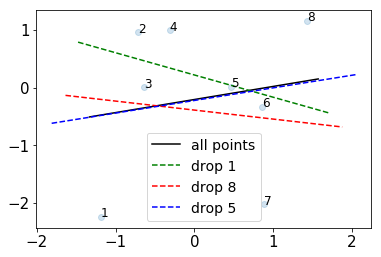

In [22]:
# figure showing biased prediction
plt.rcParams['font.size'] = 12

def abline(slope, intercept,plt_sym='-',color='k'):
    """
    Plot a line from slope and intercept
    adapted from https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib
    """
    axes = plt.gca()
    x_vals = numpy.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, plt_sym,color=color)

    
    
numpy.random.seed(1234)
X = numpy.random.randn(8)
Y = numpy.random.randn(8)
idx = numpy.argsort(X)
X = X[idx].reshape((8,1))
Y = Y[idx]

plt.scatter(X,Y,alpha=0.2)
lr = LinearRegression(fit_intercept=True)
lr.fit(X,Y)
abline(lr.coef_[0],lr.intercept_)
for i in range(8):
    plt.annotate('%d'%int(i+1),[X[i],Y[i]])
    
# compute regression lines, dropping each value
loo = LeaveOneOut()
regparams = numpy.zeros((8,2))
for train_index,test_index in loo.split(X):
    lr.fit(X[train_index],Y[train_index])
    regparams[test_index,:] = [lr.coef_[0],lr.intercept_]
    
abline(regparams[0,0],regparams[0,1],'--','g')
abline(regparams[7,0],regparams[7,1],'--','r')
abline(regparams[4,0],regparams[4,1],'--','b')

plt.legend(['all points','drop 1','drop 8','drop 5'])
plt.rcParams['legend.fontsize'] = 12

plt.savefig('Figure4_anticorrelation.png')


*Figure 4*: An example of anti-correlated regression predictions using leave-one-out crossvalidation.  The regression line fitted to the full dataset (solid black line) has a slightly positive slope.  Dropping data points near the overall regression line has little impact on the resulting slope (e.g., dashed blue line showing slope after dropping data point 5), but dropping high-leverage data points at the extremes of the X distribution has major impact on the resulting regression lines (e.g., dashed green and red lines showing impact of dropping points 1 and 8 respectively), changing the slope from positive to negative.

#### Extra: Demonstration of negative correlation between predicted and actual values with random data

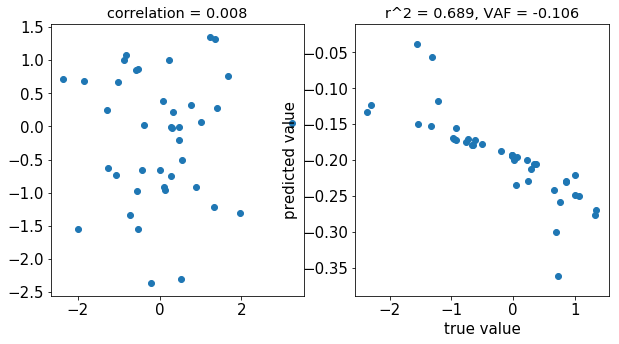

In [15]:
## generate null data and perform regression cross-validation
numpy.random.seed(12345)
npts = 40
X = numpy.random.randn(npts)
y = numpy.random.randn(npts)

loo = LeaveOneOut()
lr = LinearRegression()
pred = numpy.zeros(y.shape)
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr.fit(X_train[:,numpy.newaxis],y_train)
    pred[test_index] = lr.predict(X_test[:,numpy.newaxis])
    
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(X,y)
plt.title('correlation = %0.3f'%numpy.corrcoef(X,y)[0,1])


plt.subplot(1,2,2)
plt.scatter(y,pred)
plt.title('r^2 = %0.3f, VAF = %0.3f'%(numpy.corrcoef(y,pred)[0,1]**2,
         metrics.r2_score(y,pred)))
plt.xlabel('true value')
plt.ylabel('predicted value')

plt.savefig('cv_regression.png')

*Figure 3*: A demonstration of the problematic application of crossvalidation to continuous variables, using random data with no true predictive relationship (shown in the left panel).  The right panel shows the true value for each datapoint plotted against the predicted value using leave-one-out crossvalidation; the "r^2" value is obtained by squaring the correlation coefficient, while the variance accounted for (VAF) was computed using the scikit-learn *r2_score()* function.

#### Extra: Demonstration of bias across different types of cross validation in regression

In [16]:
def cvtest(nsubs,cv_fns=None,beta=0.2,
           scale_X=True,scale_Y=True,
          scale_within_loop=False):
    """
    - function to perform a single simulation run
    nsubs: number of subjects per simulation
    cv_fns: dict of CV functions
    beta: strength of true relationship
    measure: 'corr': correlation, 'MSE': mean squared error
    """
    results_corr=[]
    results_mse=[]
    
    if cv_fns is None:
        cv_fns={'LOO':model_selection.LeaveOneOut(),
               'BalancedKFold':BalancedKFold(nfolds=4,pthresh=0.99),
               'KFold':model_selection.KFold(n_splits=4,shuffle=True),
               'ShuffleSplit':ShuffleSplit(n_splits=5, test_size=0.3)}

    # just use simple linear regression
    clf=LinearRegression()
    
    # create random X and Y variables
    X=numpy.random.randn(nsubs).reshape((nsubs,1))
    if scale_X:
        X = (X - numpy.mean(X))/numpy.std(X)
    Y=numpy.random.randn(nsubs).reshape((nsubs,1)) + X*beta
    if scale_Y:
        Y = (Y - numpy.mean(Y))/numpy.std(Y)

    scaler=StandardScaler()
    # first run leave-one-out CV
    for method in cv_fns:
        cv=cv_fns[method]
        pred=numpy.zeros((nsubs,1))
        for train_index, test_index in cv.split(X,Y):

            X_train, X_test = X[train_index,:], X[test_index,:]
            y_train, y_test = Y[train_index], Y[test_index]
            if scale_within_loop:
                X_train=scaler.fit_transform(X_train)
                X_test=scaler.transform(X_test)
            clf.fit(X_train,y_train)

            pred[test_index,0]=clf.predict(X_test)[:,0]
        corr=numpy.corrcoef(pred[:,0],Y[:,0])[0,1]
        MSE=numpy.sqrt(numpy.mean((pred-Y[:,0])**2))
        results_corr.append([method,corr])
        results_mse.append([method,MSE])
    # also include in-sample
    clf.fit(X,Y)
    pred=clf.predict(X)
    corr=numpy.corrcoef(pred[:,0],Y[:,0])[0,1]
    MSE=numpy.sqrt(numpy.mean((pred-Y[:,0])**2))
    results_corr.append(['insample',corr])
    results_mse.append(['insample',MSE])
    return(results_corr,results_mse)
    
def plot_results(results,beta,measure):
    results_df = pandas.DataFrame(results,columns=['n','method',measure])
    seaborn.lineplot(x='n',y=measure,hue='method',data=results_df)
    plt.title('beta = %0.3f'%beta)
    if measure=='MSE':
        plt.ylim((0.99,1.07))
        plt.ylabel('Mean squared error')
    elif measure=='corr':
        plt.ylabel('Correlation(predicted,true)')
        plt.plot([results_df.n.min(),results_df.n.max()],[beta,beta],'k:')
 

def run_sim(nruns,beta,
            sampsizes=[24,48,96,192,512,1024]):
    results_corr=[]
    results_mse=[]
    for n in sampsizes:
        for run in range(nruns):
            result_corr,result_mse=cvtest(n,beta=beta)
            for r in result_corr:
                results_corr.append([n]+r)
            for r in result_mse:
                results_mse.append([n]+r)
                
    return(results_corr,results_mse)

In [17]:
beta=.2
results_corr,results_mse=run_sim(nruns=100,beta=beta)

beta_null=0.
results_corr_nosig,results_mse_nosig=run_sim(nruns=100,beta=beta_null)

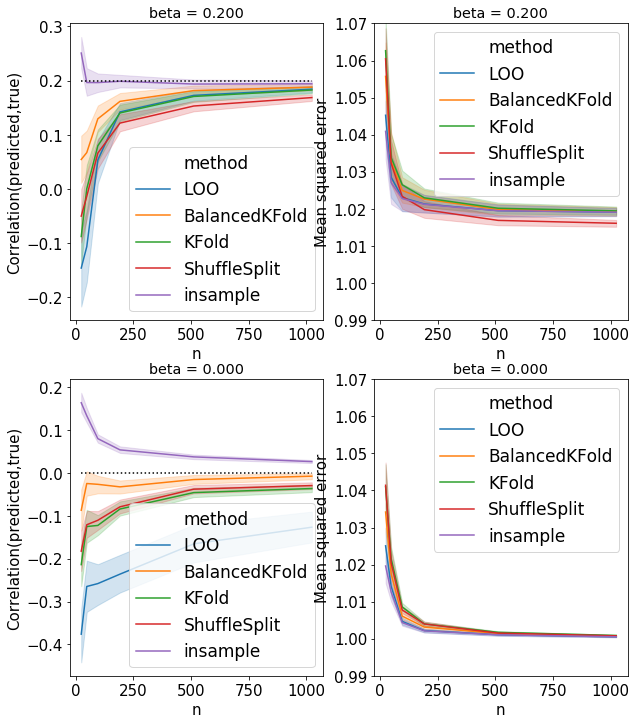

In [18]:
# Make figure

plt.figure(figsize=(10,12))
plt.subplot(2,2,1)
plot_results(results_corr,beta,'corr')

plt.subplot(2,2,2)
plot_results(results_mse,beta,'MSE')

plt.subplot(2,2,3)
plot_results(results_corr_nosig,beta_null,'corr')

plt.subplot(2,2,4)
plot_results(results_mse_nosig,beta_null,'MSE')

plt.savefig('bias_sample_size.png')

*Figure 5*: Predictive accuracy as a function of true effect size and sample size, using multiple crossvalidation methods.  The top row shows performance when there is a small true signal (r=0.2), while the bottom row shows performance under the null hypothesis. The left column shows the Pearson correlation between predicted and true values, while the right column shows the mean squared error. Red lines show data for in-sample correlation/error, while other lines show results using several crossvalidation methods; shaded area represents the 95% confidence interval computed via the bootstrap.